# Figure 9: Contrast Curves compared

This code is used to create **Figure 9** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The code computes contrast curves under two different assumptions about residual noise:
    
1. The residual noise is Gaussian. This is the classical [t-test](../../03_package/statistics.rst#applefy.statistics.parametric.TTest) as discussed in [Mawet et al. 2014](https://arxiv.org/abs/1407.2247).
2. The residual noise is Laplacian (i.e. more heavily tailed than Gaussian). This is the parametric bootstrapping test discussed in (Bonse et al. in prep.). We use the [LaplaceBootstrapTest](../../03_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest) in applefy to compute the curve.

**For more information on how to calculate contrast curves with applefy click** [here](../../02_user_documentation/01_contrast_curves.ipynb).

## Imports

In [1]:
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma, LaplaceBootstrapTest

from applefy.utils.positions import center_subpixel
from applefy.utils.file_handling import load_adi_data, read_apples_with_apples_root
from applefy.utils import flux_ratio2mag, mag2flux_ratio

## Data Loading

Figure 10 runs several fake planet experiments on the unstacked NACO data (see details in the paper). In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir/


The HR (High Temporal Resolution) data is the unstacked NACO data. Calculations with this data can be **computationally intensive**. You can also run the code with the LR (Low Temporal Resolution) data to save time.

In [3]:
# Change path to betapic_naco_lp_LR.hdf5 for low temporal resolution
dataset_file = experiment_root / Path("30_data/betapic_naco_lp_HR.hdf5")
science_data_key = "science_no_planet"
psf_template_key = "psf_template"
parang_key = "header_science_no_planet/PARANG"

dit_psf_template = 0.02019
dit_science = 0.2
fwhm = 4.2  # estimeated with Pynpoint in advance

We load the unstacked NACO data. In order to save computation time we reduce the resolution of the science sequence by cutting around the central star.

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag=science_data_key,
    psf_template_tag=psf_template_key,
    para_tag=parang_key)

psf_template = raw_psf_template_data[82:-82, 82:-82]
science_data = science_data[:, 55:-55, 55:-55]

## Compute the Contrast Curves

We use the class [Contrast](../../03_package/detections.rst#applefy.detections.contrast.Contrast) of applefy to calculate the contrast curves.

In [5]:
checkpoint_dir = experiment_root / Path("70_results/detection_limits/contrast_curves_hr")

contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    checkpoint_dir=checkpoint_dir)

### Step 1: Design fake planet experiments

In the first step we **choose** at which **separations** and for which **planet brightness** we want to insert fake planets. For analytical contrast curves we can add fake planets which are below the expected contrast (in this case 21 mag).

In [6]:
# fake planet brightness
flux_ratios_mag = 21
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: 21
Planet-to-star flux ratio: 3.981071705534969e-09


By default, separations are selected in steps of 1 FWHM from the central star to the edge of the image. **We want twice the resolution for this plot**. The separations have to be given in pixel values.

In [7]:
# We want the double resolution as in the tutorial example
center = center_subpixel(science_data[0])
separations = np.arange(2.1, center[0], fwhm/2)[1:]
separations

array([ 4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. , 23.1, 25.2,
       27.3, 29.4, 31.5, 33.6, 35.7])

For each cell in the contrast grid we calculate *num_fake_planets* (between min=1 and max=6) planet residuals.

In [8]:
num_fake_planets = 6

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


### Step 2: Run fake planet experiments

In the second step we **insert fake planetes** as chosen in the first step. For each planet we **run a full-frame PCA** to obtain a residual image. We use the [PynPoint](https://pynpoint.readthedocs.io/en/latest/) [wrappers](../../03_package/wrappers.rst) of applefy.

In [9]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

We compute the results for 5, 10, 20, 30 and 50 PCA components. For the plot later only one of the results is used.

In [10]:
components = [5, 10, 20, 30, 50]

**Make sure to choose a scratch folder which has a high bandwidth!**

In [11]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=Path("/scratch/mbonse/applefy_scratch/"),
    num_cpus_pynpoint=1)

If the results are available from previous calculations the following step will just restore the residuals.

In [12]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=33)

Running fake planet experiments...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:06<00:00, 15.09it/s]


[DONE]


### Step 3:  Compute the contrast curves

Since we are close to the star in the speckle dominated regime we use spaced pixel instead of apertures to measure the pixel and noise photometry.

In [13]:
photometry_mode_planet = AperturePhotometryMode("FS", search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P")

In [14]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

Next, we calculate the contrast curves for the [t-test](../../03_package/statistics.rst#applefy.statistics.parametric.TTest) and [LaplaceBootstrapTest](../../03_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest). In contrast to the example shown in the [user documentation](../../02_user_documentation/01_contrast_curves.ipynb) we only compute the contrast curve for 30 PCA components. The member *contrast_results* of the class [Contrast](../../03_package/detections.rst#applefy.detections.contrast.Contrast) contains a *dict* of [ContrastResults](../../03_package/detections.rst#applefy.detections.contrast.ContrastResult). These can be used to individually calculate the contrast curves of different algorithm setups.

In [15]:
# extract the ContrastResult for 30 PCA components
tmp_result = contrast_instance.contrast_results['PCA (030 components)']

Create the t-test.

In [16]:
ttest = TTest()

Compute the $5 \sigma_{\mathcal{N}}$ contrast curve with the t-test. The parameter *num_rot_iter* allows to average out the effect of where the planet and noise values are placed on the residual. More information can be found in [Figure 10](10_Rotation.ipynb).

In [17]:
median_contrast_gauss, contrast_error_gauss = tmp_result.compute_analytic_contrast_curve(
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    statistical_test=ttest,
    num_rot_iter=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:11<00:00,  8.24s/it]


The same for the LaplaceBootstrapTest.

In [18]:
pbs_laplace_statistic = LaplaceBootstrapTest.construct_from_json_file(
    experiment_root / Path("lookup_tables/laplace_lookup_tables.csv"))

In [19]:
median_contrast_laplace, contrast_error_laplace = tmp_result.compute_analytic_contrast_curve(
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    statistical_test=pbs_laplace_statistic,
    num_rot_iter=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:20<00:00,  8.81s/it]


## Create the Plot

Define the colors we use.

In [20]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1]]

The separations in the tmp_result are in pixel. We convert them to FWHM.

In [21]:
separations = np.round(np.array([i / fwhm for i in tmp_result.idx_table.index]), 2)

A small helper function to plot a contrast curve with error bars.

In [22]:
def plot_contrast_curve(separations,
                        median_contrast,
                        contrast_error,
                        label, 
                        axis, 
                        color):
    axis.plot(separations, 
              flux_ratio2mag(median_contrast), 
              label=label,
              lw=2,
              color=color)
    
    axis.fill_between(
        separations,
        flux_ratio2mag(median_contrast + contrast_error * 2), 
        flux_ratio2mag(median_contrast - contrast_error * 2),
        alpha=0.5)

Create the final figure.

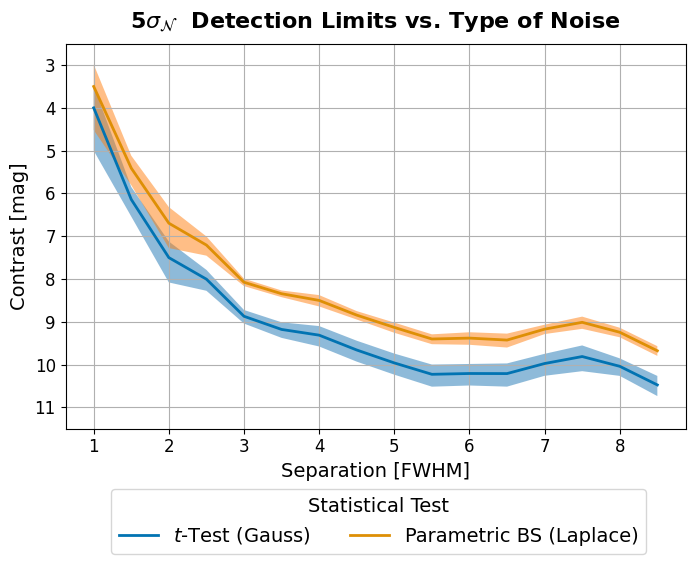

In [23]:
# 1.) Create Plot Layout -----------------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 5))
gs0 = fig.add_gridspec(1, 1)

axis_pca = fig.add_subplot(gs0[0, 0])

# 2.) Make the plot
plot_contrast_curve(separations, 
                    median_contrast_gauss.values.flatten(), 
                    contrast_error_gauss.values.flatten(),
                    "$t$-Test (Gauss)", 
                    axis_pca,
                    color=color_palette[0])

plot_contrast_curve(separations, 
                    median_contrast_laplace.values.flatten(), 
                    contrast_error_laplace.values.flatten(), 
                    "Parametric BS (Laplace)", 
                    axis_pca,
                    color=color_palette[1])

axis_pca.grid()

# 3.) Set limits -------------------------------------------------------
axis_pca.set_ylim(11.5, 2.5)
axis_pca.tick_params(axis='both', which='major', labelsize=12)

# 4.) Set Labels -------------------------------------------------------
axis_pca.set_xlabel(r"Separation [FWHM]", size=14)
axis_pca.set_ylabel(r"Contrast [mag]", size=14)

axis_pca.set_title(
    r"5$ \sigma_{\mathcal{N}}$  Detection Limits vs. Type of Noise",
    fontsize=16, fontweight="bold", y=1.02)

# 5.) Legend -----------------------------------------------------------
handles, labels = axis_pca.get_legend_handles_labels()
leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.17, -0.16), 
                  fontsize=14, 
                  title="Statistical Test",
                  loc='lower left', ncol=2)
plt.setp(leg1.get_title(),fontsize=14)

# 5.) Save the Plot ----------------------------------------------------
fig.patch.set_facecolor('white')
plt.savefig("./09_Contrast_curves.pdf",
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')